In [1]:
'''
Zé Fonseca

23/02/16

Notes: Data sets are classes and cases inside each dataset is a subclass

This ipython notebook simulates the data, has diferent log likelyhoods for the MCMC on top of the MCMC. 
Also has plot functions.  
'''

import numpy as np
import scipy as sp
from scipy.integrate import quad
import matplotlib.pyplot as plt
from scipy.interpolate import griddata, splrep, splev, bisplrep, bisplev
import sys
from copy import deepcopy

%matplotlib inline

#### Part 1

## Simulating data

### Cases:
* 1: N_SNeIa=1000, z-[0.015,1.0], \sigma_mu=0.2 (both in the distribution and in the error bar), no z scatter;
* 2.1: z scatter=0.04*(1+z) but all z are positive 
* 2.2: z scatter=0.04*(1+z) only for z>0.1 (bellow we expect to have spectroscopic info)
* 3: 9% of the z are wrong (but we don't know which ones), on avarage Delta_z\sim 0.1

Note that for now error bars on mu will be given by 0.2. Error propagation in quadrature will be done later.

In [2]:
#cosmological functions
#general functions

def invH(z,OM,w):
    return (OM*(1+z)**3+(1-OM)*(1+z)**(3*(w+1)))**(-.5)

c=2.99792e5

def mu(z,OM,H0,w):
    if type(z)=='float' or type(z)=='int':
        return 5*np.log10((1+z)/H0*c*quad(invH,0,z,args=(OM,w))[0])+25
    else:
        dl=[]
        for i in range(len(z)):
            dl.append(quad(invH,0,z[i],args=(OM,w))[0])
        return 5*np.log10(np.array(dl)*(1+z)*c/H0)+25

#class fake data with all the cases.

class fkd:
    def __init__(self,name,filename,OM=0.31,H0=67.74,w=-1,sig_mu=0.01):
        #parameters used
        self.OM=OM
        self.H0=H0
        self.w=w
        self.dataset=name
        
        dados=np.loadtxt(filename)
        self.z=dados[:,0]
        self.mu_o=dados[:,1]
        self.sig_mu=sig_mu
        

In [3]:
#initiate data
fd1=fkd('cosmoSNe_1','general_datasets/data_cosmoSNe_1.txt')
fd2=fkd('cosmoSNe_2','general_datasets/data_cosmoSNe_2.txt')
fd3=fkd('cosmoSNe_3','general_datasets/data_cosmoSNe_3.txt')
fd4=fkd('cosmoSNe_4','general_datasets/data_cosmoSNe_4.txt')
fd5=fkd('cosmoSNe_5','general_datasets/data_cosmoSNe_5.txt')


# Part 2

## Do the MCMC to the data

Notes: when adding errors in MCMC we need 3 different error adding. Case 3 does not have mu errors increased in quadrature. 

In [4]:
# Functions

#MCMC priors
def prior_om(x):
    if x>=0 and x<=1:
        return 1
    else:
        return 0
    
def prior_w(x):
    if x>=-6 and x<=4:
        return 1
    else:
        return 0
    
def prior_H0(x):
    if x>=10 and x<=200:
        return 1
    else:
        return 0
    
def chi2(mu_o,mu_t,sigma2):
    return (mu_o-mu_t)**2/sigma2



In [5]:
def log_like_fixsig(data,om,H0,w):
    mu_t=mu(data.z,om,H0,w)
    return -chi2(data.mu_o,mu_t,data.sig_mu**2)/2


In [6]:
def MCMC_SNe(N,data,loglike_func=log_like_fixsig):
    #create arrays
    o_m=np.zeros(N)
    w=np.zeros(N)
    H0=np.zeros(N)
    log_like=np.zeros(N)
    
    #set starting point
    o_m[0]=0.3
    w[0]=-0.9
    H0[0]=70
    log_like[0]=sum(loglike_func(data,o_m[0],H0[0],w[0]))
    
    #dummy var for acceptance rate
    accept=1
    for i in range(N-1):
        #get new point
        o_m[i+1]=o_m[i]+np.random.randn()*0.07
        w[i+1]=w[i]+np.random.randn()*0.07
        H0[i+1]=H0[i]+np.random.randn()*1.3
        
        if prior_om(o_m[i+1])==0 or prior_w(w[i+1])==0 or prior_H0(H0[i+1])==0:
            o_m[i+1]=o_m[i]
            w[i+1]=w[i]
            H0[i+1]=H0[i]
            log_like[i+1]=log_like[i]
            continue
        else:
            #compute new log_like
            log_like[i+1]=sum(loglike_func(data,o_m[i+1],H0[i+1],w[i+1]))
            #if priors not flat they need to be included after the exp. for now flat prior
            r=sp.exp(log_like[i+1]-log_like[i])
            #accept or not
            teste=np.random.rand()
            if r<teste:
                o_m[i+1]=o_m[i]
                w[i+1]=w[i]
                H0[i+1]=H0[i]
                log_like[i+1]=log_like[i]
                continue
        
        accept+=1  
            
                
        #really cool piece of code from Ethan
        inc100 = np.int64(i/(N)*100)
        inc50 = np.int64(i/(N)*50)
        sys.stdout.write('\r')
        sys.stdout.write('[' + '#'*inc50 + ' '*(50-inc50) + ']' + str(inc100) + '%')
        sys.stdout.flush()
        
    acceptr=accept/N*100
    data.acceptr=acceptr
    data.chain_o_m=o_m
    data.chain_w=w
    data.chain_H0=H0
    data.log_like=log_like
    data.acceptr=acceptr    

## Make plots

In [7]:
def confidence_levels(Hist,N):
    H2d=Hist.ravel()
    H2d = np.sort(H2d)
    tot=np.cumsum(H2d)
    Nmax=H2d[-1]
    N95=H2d[np.argwhere(tot>0.05*N)[0,0]]
    N68=H2d[np.argwhere(tot>0.32*N)[0,0]]
    return Nmax,N68,N95

def plot_contour_hist_1(data1,burn_tail=500,thining=1,nb=10):    
    #o_m,w,H0,case,dataset,,hotext=[66,6000]):
    f, axarr = plt.subplots(2, 2,figsize=(12,8),gridspec_kw = {'width_ratios':[2,1],'height_ratios':[1,2]})
    
    
    Hist_mcmc, omedges,wedges = np.histogram2d(data1.chain_o_m[burn_tail::thining],data1.chain_w[burn_tail::thining],bins=(nb, nb))
    om_c=np.array([(omedges[i]+omedges[i+1])/2 for i in range(len(omedges)-1)])
    w_c=np.array([(wedges[i]+wedges[i+1])/2 for i in range(len(wedges)-1)])
    Neff=len(data1.chain_o_m[burn_tail::thining])
    Nmax,N68,N95=confidence_levels(Hist_mcmc,Neff)
    #plt.plot(om_max,w_max,'rx',ms=10)
    
    bins_om=[round(x*0.025,3) for x in range(0,40)]
    bins_w=[round(x*0.05-5,3) for x in range(0,120)]
    bins_H=[x*0.25+50 for x in range(0,120)]

        
    om_min=np.amin(data1.chain_o_m[burn_tail::thining])
    om_max=np.amax(data1.chain_o_m[burn_tail::thining])
    
    w_min=np.amin(data1.chain_w[burn_tail::thining])
    w_max=np.amax(data1.chain_w[burn_tail::thining])
    
    H0_min=np.amin(data1.chain_H0[burn_tail::thining])
    H0_max=np.amax(data1.chain_H0[burn_tail::thining])
               
    axarr[0,0].hist(data1.chain_o_m[burn_tail::thining],color='r',bins=bins_om,alpha=0.05)
    axarr[0,0].set_xlim([om_min,om_max])
    axarr[0,0].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    
    axarr[1,0].contour(om_c,w_c, Hist_mcmc.T,levels=[N95,Nmax])
    axarr[1,0].set_xlim([om_min,om_max])
    axarr[1,0].set_ylim([w_min,w_max])
    axarr[1,0].set_ylabel(r'$w$')
    axarr[1,0].set_xlabel(r'$\Omega_M$')
    
    axarr[0,1].hist(data1.chain_H0[burn_tail::thining],bins=bins_H,color='r',alpha=0.05)
    axarr[0,1].set_xlim([H0_min,H0_max])
    axarr[0,1].set_xlabel(r'$H_0$')
    
    
    axarr[1,1].hist(data1.chain_w[burn_tail::thining],bins=bins_w,color='r',alpha=0.05,orientation=u'horizontal')
    axarr[1,1].set_ylim([w_min,w_max])
    axarr[1,1].ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    
def plot_conv_mcmc(data,burn_tail=0,thining=1):
    
    f, axarr = plt.subplots(3,1,figsize=(8,12))
    
    om=data.chain_o_m[burn_tail::thining]
    w=data.chain_w[burn_tail::thining]
    H0=data.chain_H0[burn_tail::thining]
        
    axarr[0].plot(om)
    axarr[0].set_ylim([np.amin(om),np.amax(om)])
    axarr[0].set_ylabel(r'$\Omega_M$')
    
    axarr[1].plot(w)
    axarr[1].set_ylim([np.amin(w),np.amax(w)])
    axarr[1].set_ylabel(r'$w$')
    
    axarr[2].plot(H0)
    axarr[2].set_ylim([np.amin(H0),np.amax(H0)])
    axarr[2].set_ylabel(r'$H_0$')
    
    plt.setp(axarr[0].get_xticklabels(), visible=False)
    plt.setp(axarr[1].get_xticklabels(), visible=False)
    
    plt.show()

# Run for dataset 

In [8]:
Nsteps=100000

In [10]:
MCMC_SNe(Nsteps,fd1,log_like_fixsig)
print('\n',fd1.acceptr)


[################################################# ]99%
 2.643


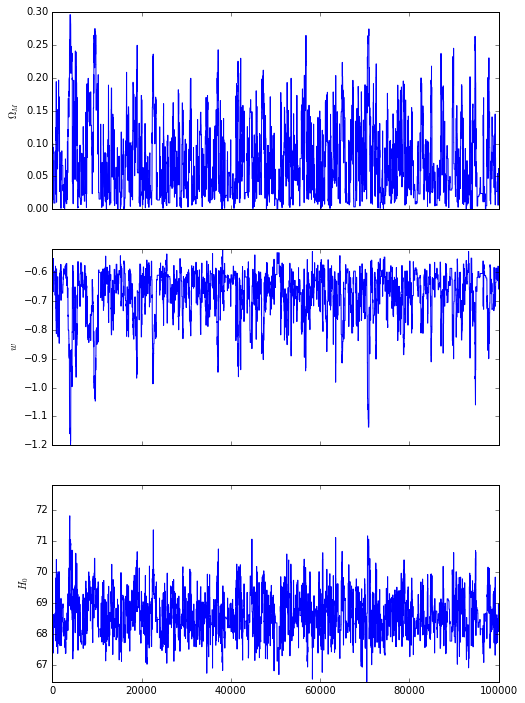

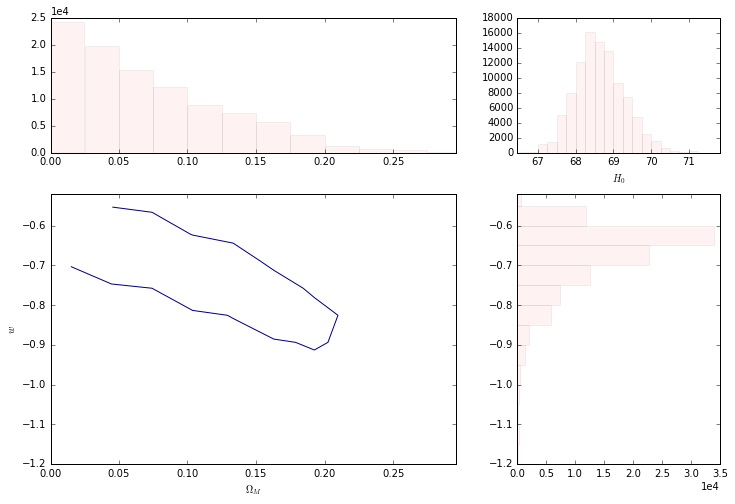

In [11]:
plot_conv_mcmc(fd1)
plot_contour_hist_1(fd1)
plt.show()

[################################################# ]99%
 2.83


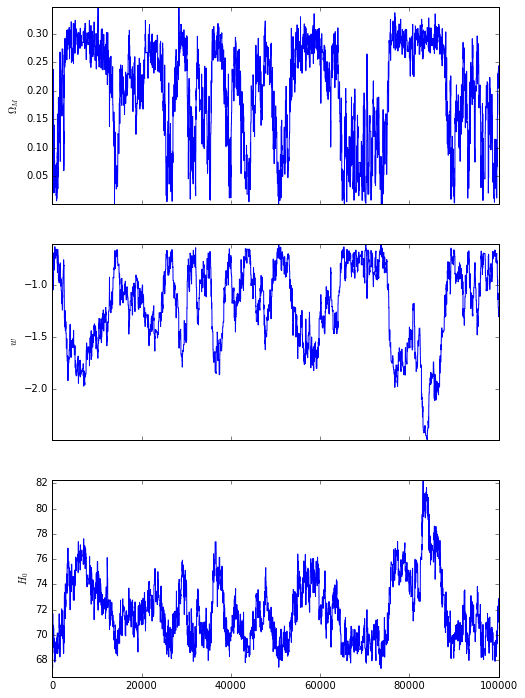

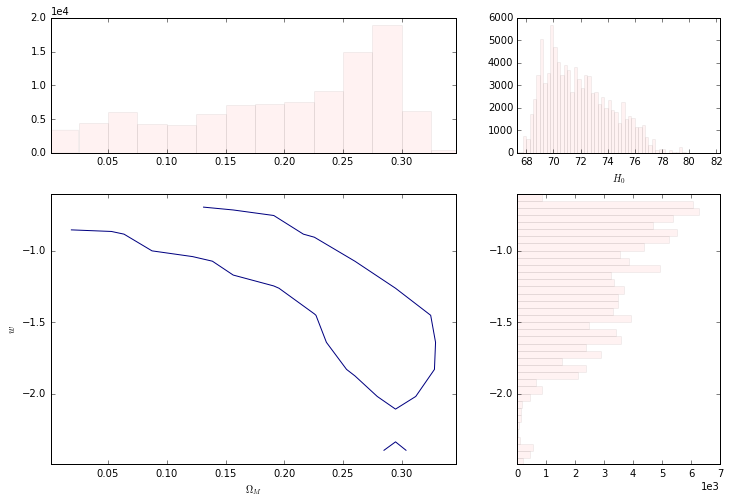

In [12]:
MCMC_SNe(Nsteps,fd2,log_like_fixsig)
print('\n',fd2.acceptr)
plot_conv_mcmc(fd2)
plot_contour_hist_1(fd2)
plt.show()

[################################################# ]99%
 5.242


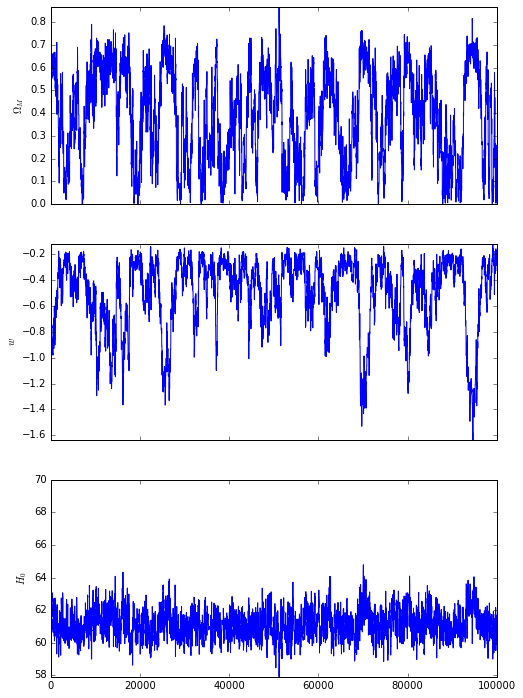

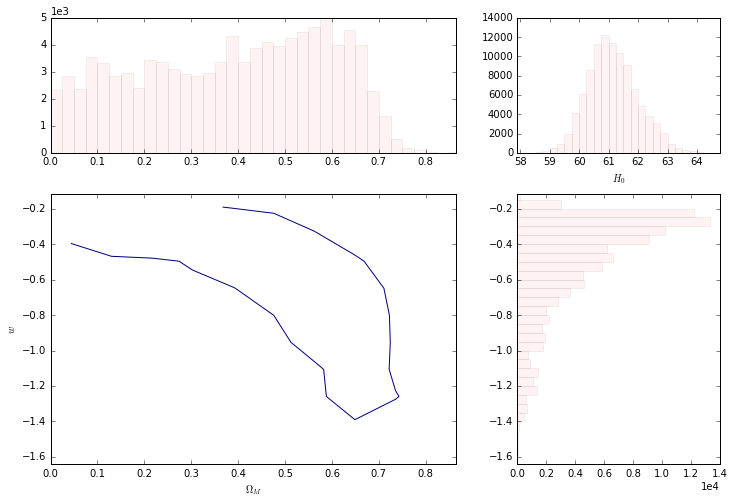

In [13]:
MCMC_SNe(Nsteps,fd3,log_like_fixsig)
print('\n',fd3.acceptr)
plot_conv_mcmc(fd3)
plot_contour_hist_1(fd3)
plt.show()

[################################################# ]99%
 2.794


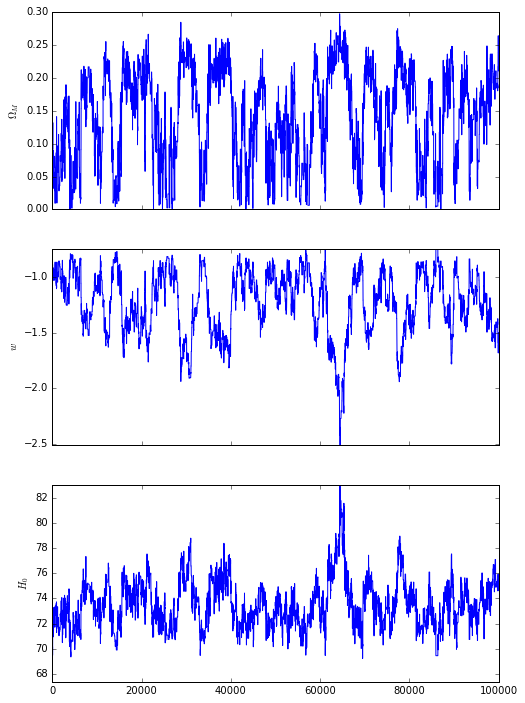

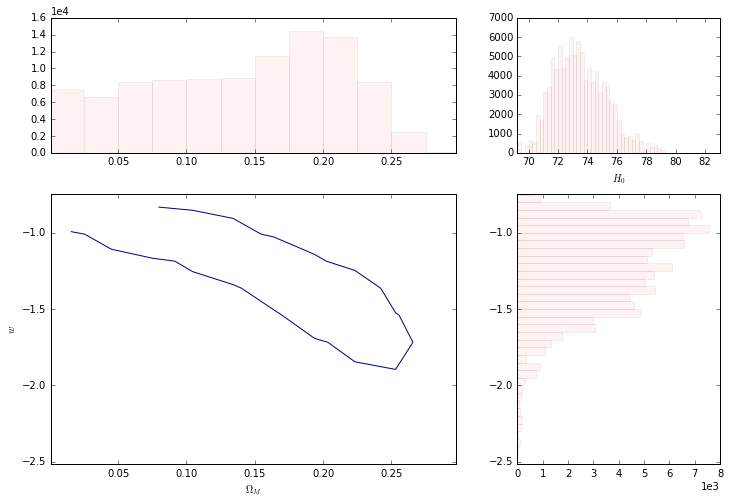

In [14]:
MCMC_SNe(Nsteps,fd4,log_like_fixsig)
print('\n',fd4.acceptr)
plot_conv_mcmc(fd4)
plot_contour_hist_1(fd4)
plt.show()

[################################################# ]99%
 2.589


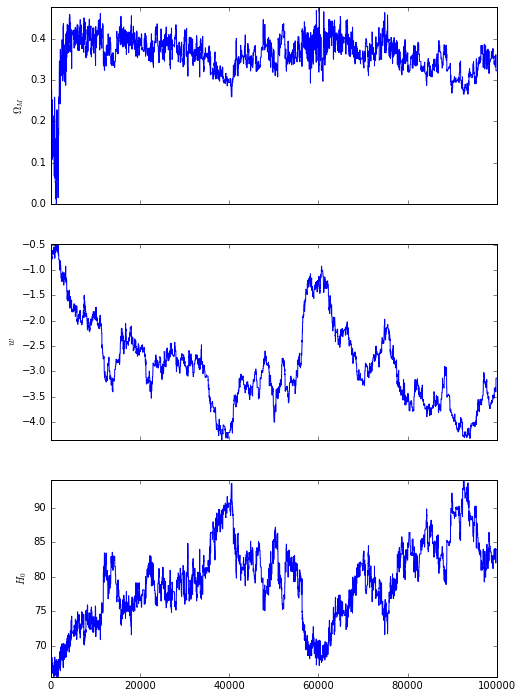

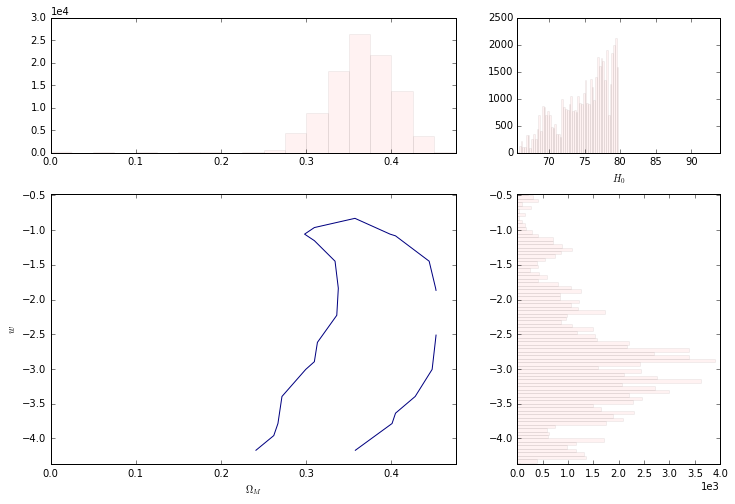

In [15]:
MCMC_SNe(Nsteps,fd5,log_like_fixsig)
print('\n',fd5.acceptr)
plot_conv_mcmc(fd5)
plot_contour_hist_1(fd5)
plt.show()

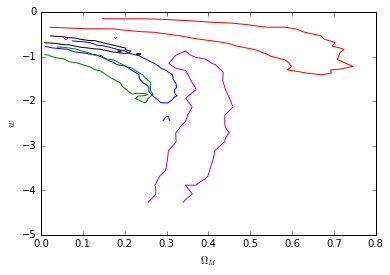

In [23]:
datas={'0':fd1,'1':fd2,'2':fd3,'3':fd4,'4':fd5}
nb=20
cor=['k','b','r','g','m']
for i in range(5):
    Hist_mcmc, omedges,wedges = np.histogram2d(datas[str(i)].chain_o_m,datas[str(i)].chain_w,bins=(nb, nb))
    om_c=np.array([(omedges[i]+omedges[i+1])/2 for i in range(len(omedges)-1)])
    w_c=np.array([(wedges[i]+wedges[i+1])/2 for i in range(len(wedges)-1)])
    Nmax,N68,N95=confidence_levels(Hist_mcmc,Nsteps)
    #plt.plot(om_max,w_max,'rx',ms=10)
    plt.contour(om_c,w_c, Hist_mcmc.T,levels=[N95,Nmax],colors=cor[i])
    
    
plt.xlim([0,0.8])
plt.ylim([-5,0])
plt.ylabel(r'$w$')
plt.xlabel(r'$\Omega_M$')

plt.savefig('general_datasets/5cosmo_chains.png')
plt.show()

In [24]:
def save_mcmc(data):
    np.savetxt('general_datasets/chains_'+data.dataset+'.txt',np.c_[data.chain_o_m,data.chain_w,data.chain_H0,data.log_like],\
                   fmt=['%2.3f','%2.3f','%2.3f','%2.3f'],header='\n'.join(["acceptance rate %.2f" %data.acceptr,\
                                                                           "Om   w   H0   log_like"]))

In [25]:
for i in range(5):
    save_mcmc(datas[str(i)])